# Deep learning

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

In this notebook we demonstrate how deep neural networks can be easily used together with OpenCV.

## Image recognition
Credits to Adrian Rosebrock (https://www.pyimagesearch.com/2017/08/21/deep-learning-with-opencv/)

We use GoogleNet ([Szegedy et al., 2015](https://arxiv.org/abs/1409.4842)), the winner of ILSVRC 2014, to categorize input images to one of 1000 classes. The network we use is a pretrained Caffe model. See [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) for details how to download the model.


In [3]:
net = cv2.dnn.readNetFromCaffe('models/bvlc_googlenet.prototxt', 'models/bvlc_googlenet.caffemodel')

Next, we preprocess the category labels.

In [4]:
rows = open('models/classification_classes_ILSVRC2012.txt').read().strip().split("\n")

In [5]:
classes = [r.split(",")[0] for r in rows]

Then we define a function for performing the actual image recognition. The label is added to the image.

In [6]:
def image_recognize(img):
    blob = cv2.dnn.blobFromImage(img, 1, (224, 224), (104, 117, 123))
    net.setInput(blob)
    preds = net.forward()
    idxs = np.argsort(preds[0])[::-1][:5]
    idx = idxs[0]
    text = "Label: {}, {:.2f}%".format(classes[idx], preds[0][idx] * 100)
    res = cv2.putText(img, text, (5, 25),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    return res, idxs

Let's try the code with a test image found from scikit-image package.

In [7]:
img = data.chelsea()

In [8]:
res, idxs = image_recognize(img)

(-0.5, 450.5, 299.5, -0.5)

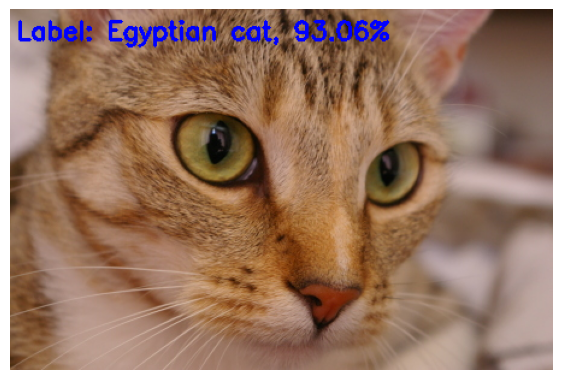

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(res)
plt.axis('off')

Here is another test image.

In [10]:
img = data.coffee()

In [11]:
res, idxs = image_recognize(img)

(-0.5, 599.5, 399.5, -0.5)

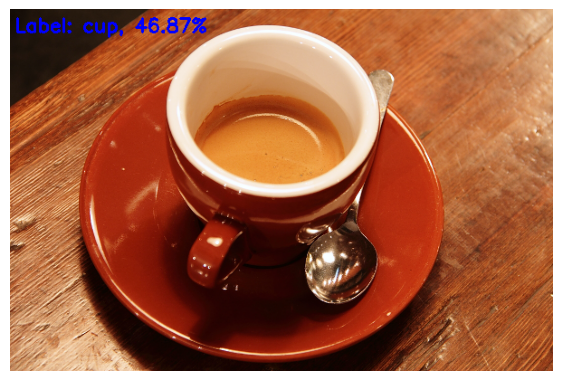

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(res)
plt.axis('off')

And a third one.

In [13]:
img = data.astronaut()

In [14]:
res, idxs = image_recognize(img)

(-0.5, 511.5, 511.5, -0.5)

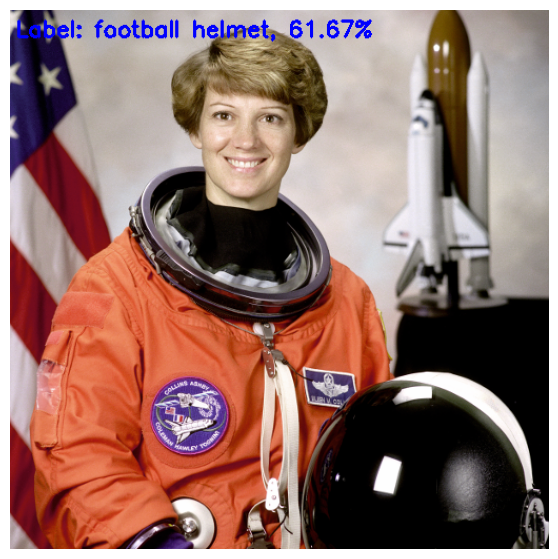

In [15]:
plt.figure(figsize=(7,7))
plt.imshow(res)
plt.axis('off')

Now, we can see that the result is somewhat incorrect. Let's still check all top 5 results provided by the network.

In [16]:
for i in idxs:
    print(classes[i])

football helmet
bobsled
crash helmet
neck brace
punching bag


The reason for the failure is that there is no matching category in the ILSVRC2012 dataset.

## Semantic segmentation
In the second part we use the fully convolutional neural network proposed by [Long et al. 2015](https://ieeexplore.ieee.org/document/7298965) to segment the input images to 20 predefined categories. See [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) for details how to download the Caffe model.

In [17]:
net = cv2.dnn.readNetFromCaffe('models/deploy.prototxt', 'models/fcn8s-heavy-pascal.caffemodel')

Here are the categories.

In [18]:
rows = open('models/object_detection_classes_pascal_voc.txt').read().strip().split("\n")

In [19]:
classes = [r.split(",")[0] for r in rows]

In [20]:
classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

We use helper functions found from [vis.py](https://github.com/shelhamer/fcn.berkeleyvision.org) to visualize the categories with different colors.

In [21]:
import models.vis as vis

In [22]:
voc_palette = vis.make_palette(21)

We also create a colorbar to show the categories.

In [23]:
n = len(classes)
pal = np.zeros((n*20, 150), dtype=np.uint8)
for i in range(n):
    pal[i*20:(i+1)*20,:] = i+1
pal = vis.color_seg(pal, voc_palette)

In [24]:
for i in range(n):
    text = classes[i]
    pal = cv2.putText(pal, text, (5, 15+20*i),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

(-0.5, 149.5, 399.5, -0.5)

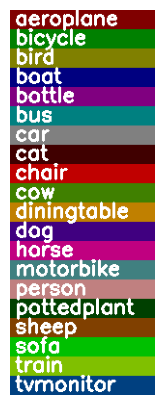

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(pal)
plt.axis('off')

Then we implement a function for performing the segmentation.

In [26]:
def semantic_segmentation(img):
    img = img[:,:,::-1].astype(np.float32)
    img -= np.array((104.00698793,116.66876762,122.67891434))
    img = img.transpose((2,0,1))
    img = img.reshape(1,*img.shape)
    net.setInput(img)
    preds = net.forward()
    out = preds[0].argmax(axis=0)
    return out

Now, we are ready to test the method. This is the first image.

In [27]:
img = data.astronaut()

In [28]:
out = semantic_segmentation(img)

(-0.5, 511.5, 511.5, -0.5)

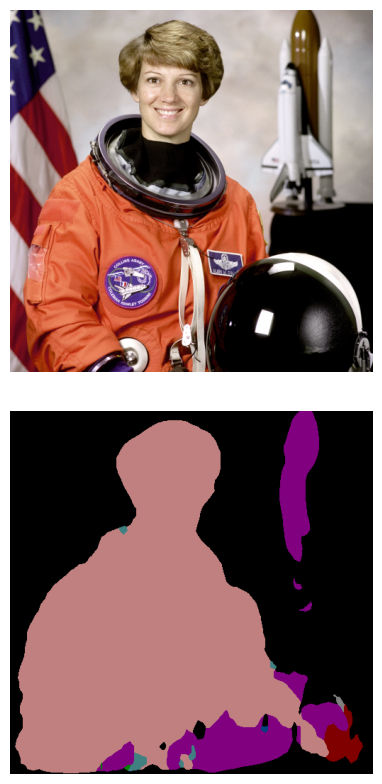

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.tight_layout()
plt.imshow(img)
plt.axis('off')
plt.subplot(212)
plt.imshow(vis.color_seg(out, voc_palette))
plt.axis('off')

Here are two other examples.

In [30]:
img = cv2.imread('images/voc_26.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [31]:
out = semantic_segmentation(img)

(-0.5, 499.5, 374.5, -0.5)

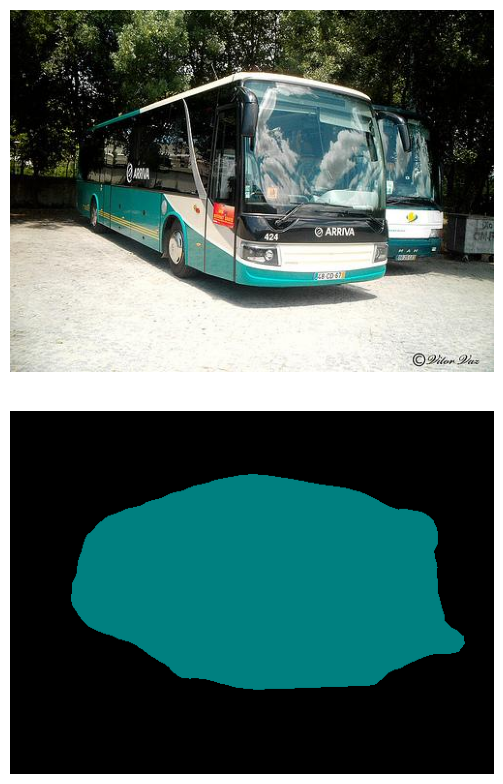

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.tight_layout()
plt.imshow(img)
plt.axis('off')
plt.subplot(212)
plt.imshow(vis.color_seg(out, voc_palette))
plt.axis('off')

In [33]:
img = cv2.imread('images/voc_07.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [34]:
out = semantic_segmentation(img)

(-0.5, 417.5, 291.5, -0.5)

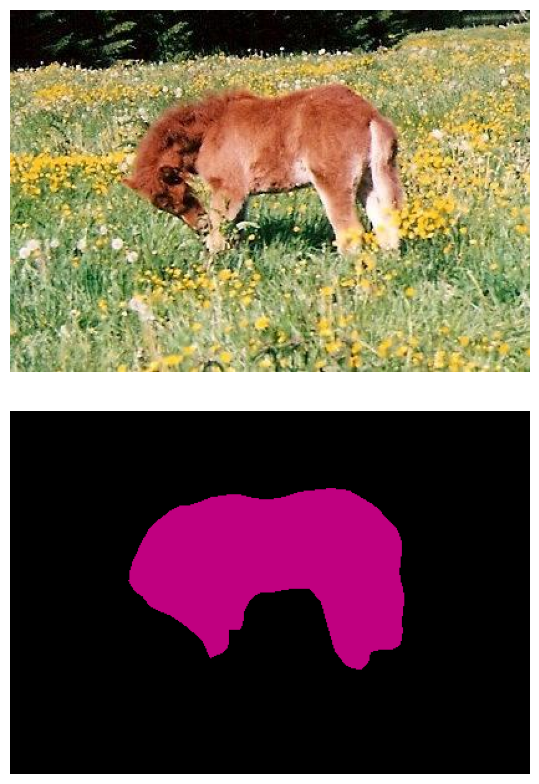

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.tight_layout()
plt.imshow(img)
plt.axis('off')
plt.subplot(212)
plt.imshow(vis.color_seg(out, voc_palette))
plt.axis('off')